# Chilbolton Source Inversion Simulation
-------------------------------

This notebook was used to sdiagnose the lack of convergence when estimating parameters for the  Chilbolton's Source 3 and Source 4 data. We simulated sources with identical locations and emission rates and estimate parameters under good simulated wind coverage degree conditions.

<div class="alert alert-block alert-warning">
<b>PACKAGE REQUIREMENT:</b> Package "sourceinversion". Install using:<br>
pip install -q sourceinversion
</div>

In [19]:
# pip install -q sourceinversion

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/...
</div>

<br><br><br>

### Importing "sourceinversion" package 

In [20]:
import sourceinversion.atmospheric_measurements as gp
import sourceinversion.mcmc as mcmc

### Libraries

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
from jax import config
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
import itertools
from jax import lax
from pyDOE import lhs
import pickle

config.update("jax_enable_x64", True)



<br>

## 1. Chilbolton Gas Sensors' Layout

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Sensor_reflector_locations/Chilbolton_instruments_location.pkl
</div>

In [22]:
with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Sensor_reflector_locations/Chilbolton_instruments_location.pkl', 'rb') as f:
    instruments_location = pickle.load(f)

creating integration points along beam every 0.40 meters

In [23]:
number_of_point_sensors = {
    "reflector_1": 18*5,
    "reflector_2": 33*5,
    "reflector_3": 22*5,
    "reflector_4": 49*5,
    "reflector_5": 42*5,
    "reflector_6": 29*5,
    "reflector_7": 17*5,
}

In [24]:
def get_equally_spaced_points(point1, point2, num_points):
    # Calculate the step size for each dimension
    step_size = [(p2 - p1) / (num_points - 1) for p1, p2 in zip(point1, point2)]

    # Calculate the coordinates of the equally spaced points
    points = [[p1 + i * step for p1, step in zip(point1, step_size)] for i in range(num_points)]

    return points

point_sensors_1_location = get_equally_spaced_points(instruments_location["line_of_sight_sensor"], instruments_location["reflector_1"], number_of_point_sensors["reflector_1"])
point_sensors_2_location = get_equally_spaced_points(instruments_location["line_of_sight_sensor"], instruments_location["reflector_2"], number_of_point_sensors["reflector_2"])
point_sensors_3_location = get_equally_spaced_points(instruments_location["line_of_sight_sensor"], instruments_location["reflector_3"], number_of_point_sensors["reflector_3"])
point_sensors_4_location = get_equally_spaced_points(instruments_location["line_of_sight_sensor"], instruments_location["reflector_4"], number_of_point_sensors["reflector_4"])
point_sensors_5_location = get_equally_spaced_points(instruments_location["line_of_sight_sensor"], instruments_location["reflector_5"], number_of_point_sensors["reflector_5"])
point_sensors_6_location = get_equally_spaced_points(instruments_location["line_of_sight_sensor"], instruments_location["reflector_6"], number_of_point_sensors["reflector_6"])
point_sensors_7_location = get_equally_spaced_points(instruments_location["line_of_sight_sensor"], instruments_location["reflector_7"], number_of_point_sensors["reflector_7"])


<br>

## 2. Chilbolton Source 3 and Source 4

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Source_locations_and_emission_rates/Chilbolton_sources_locations_and_emission_rates.pkl
</div>

In [25]:
with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Source_locations_and_emission_rates/Chilbolton_sources_locations_and_emission_rates.pkl', 'rb') as f:
    sources = pickle.load(f)

In [26]:
# Grid specification based on the Chilbolton terrain dimensions
# (used grid Search parameter initialisation or grid-based inversion)
grid = gp.Grid(
    x_range = (jnp.array(0.0), jnp.array(110.0)), 
    y_range = (jnp.array(0.0), jnp.array(110.0)),
    z_range= (jnp.array(0.0), jnp.array(0.0)),
    dx = jnp.array(0.1),
    dy = jnp.array(0.1),
    dz = jnp.array(1),
)


# Source 3 and Source 4 location
source_location = gp.SourceLocation(
    source_location_x = jnp.array([sources["source_3_location"][0], sources["source_4_location"][0]]),
    source_location_y = jnp.array([sources["source_3_location"][1], sources["source_4_location"][1]]),
    source_location_z = jnp.array([sources["source_3_location"][2], sources["source_4_location"][2]]),
)

# Wind field
wind_field = gp.WindField(
    Ornstein_Uhlenbeck = False,
    initial_wind_speed = jnp.array(6.0),
    initial_wind_direction = jnp.array(40),
    end_wind_direction = jnp.array(310),
    number_of_time_steps = int(jnp.array(230)),
    time_step = jnp.array(1.0),
    wind_speed_temporal_std = jnp.array(0.1),
    wind_direction_temporal_std = jnp.array(10.0),
    wind_temporal_correlation = jnp.array(0.5),
    wind_speed_seed = 2,
    wind_direction_seed = 4,
)


# Atmospheric State
atmospheric_state = gp.AtmosphericState(
    emission_rate = jnp.array([sources["source_3_emission_rate"], \
                            sources["source_4_emission_rate"]]),              
    source_half_width = jnp.array(1.0),                                 # Source is a square of 2m side length
    max_abl = jnp.array(1000.0),
    background_mean = jnp.array(2.0),       
    background_std = jnp.array(1e-2),       
    background_seed = jnp.array(56),
    background_filter = "power_law",        
    Gaussian_filter_kernel = 1,
    horizontal_opening_angle= 10.0,
    vertical_opening_angle = 10.0,
    a_horizontal = 1.0,
    a_vertical = 1.0,          
    b_horizontal = 1.0,
    b_vertical = 1.0,  
)

# Sensor layout
def flatten_list_of_lists(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

sensors_settings =  gp.SensorsSettings(
    layout = 'line',
    sensor_number = jnp.array(7),
    measurement_error_var = jnp.array(1e-6),
    sensor_seed = jnp.array(5),
    measurement_error_seed = jnp.array(420),
    sensor_locations =  flatten_list_of_lists([point_sensors_1_location, point_sensors_2_location, point_sensors_3_location, point_sensors_4_location, point_sensors_5_location, point_sensors_6_location, point_sensors_7_location]), 
)


# Gaussian Plume model
gaussianplume = gp.GaussianPlume(grid, source_location, wind_field, atmospheric_state, sensors_settings)

fixed  = gaussianplume.fixed_objects_of_gridfree_chilbolton_coupling_matrix(simulation = True, wind_direction=None, wind_speed=None, tangamma_ts = None, number_of_time_steps=wind_field.number_of_time_steps, source3and4=False, release_17=False)
fixed_ref1 = fixed[0], fixed[7], fixed[14], fixed[15], fixed[35], fixed[36], fixed[16], fixed[37], fixed[44]
fixed_ref2 = fixed[1], fixed[8], fixed[17], fixed[18], fixed[35], fixed[36], fixed[19], fixed[38], fixed[45]
fixed_ref3 = fixed[2], fixed[9], fixed[20], fixed[21], fixed[35], fixed[36], fixed[22], fixed[39], fixed[46]
fixed_ref4 = fixed[3], fixed[10], fixed[23], fixed[24], fixed[35], fixed[36], fixed[25], fixed[40], fixed[47]
fixed_ref5 = fixed[4], fixed[11], fixed[26], fixed[27], fixed[35], fixed[36], fixed[28], fixed[41], fixed[48]
fixed_ref6 = fixed[5], fixed[12], fixed[29], fixed[30], fixed[35], fixed[36], fixed[31], fixed[42], fixed[49]
fixed_ref7 = fixed[6], fixed[13], fixed[32], fixed[33], fixed[35], fixed[36], fixed[34], fixed[43], fixed[50]


# Parameter priors
priors = mcmc.Priors(
    # Slab allocation rate prior (used in grid-based inversion)
    theta = 0.1,

    # Emission rate (log(s)): Log scale Slab and spike prior (used in grid-based inversion)
    log_spike_mean = -25.0,
    log_spike_var = 10.0,
    log_slab_mean = -7.5,
    log_slab_var = 1.5,

    # Source location (x,y):
    source_location_x_mean = 50.0,
    source_location_x_var = 25.0,
    source_location_y_mean = 50.0,
    source_location_y_var = 25.0,

    # Measurement error variance (sigma squared)
    sigma_squared_con = 1e-11,
    sigma_squared_rate = 1e-8,

    # Background gas concentration (beta)
    mean_background_prior = 1.92,
    variance_background_prior = 0.1**2,

    # Dispersion parameter (a_H, a_V, b_H, b_V)
    a_mean = jnp.log(0.6),
    a_var = 0.5**2,
    b_mean = jnp.log(0.6),
    b_var = 0.2**2,
)

<br>
<br>
<br>

#### 4. MCMC

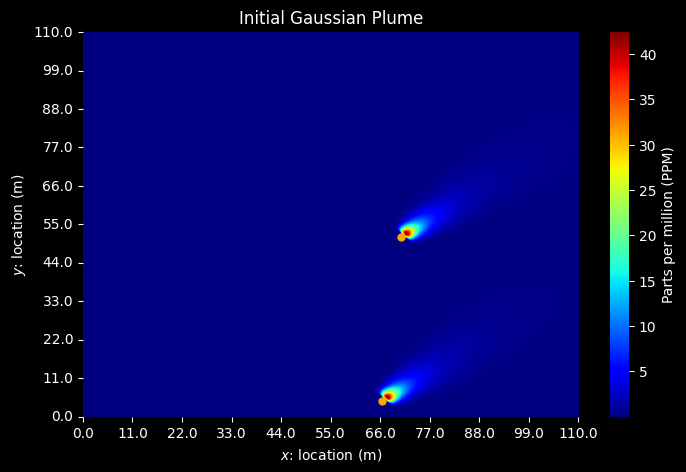

In [27]:
save= False
## Gaussian plume Class : ---------------------------------------------
gaussianplume = gp.GaussianPlume(grid, source_location, wind_field, atmospheric_state, sensors_settings)
gaussianplume.gaussian_plume_plot(save, format='png')


In [28]:
background = gp.BackgroundGas(grid, source_location, atmospheric_state)

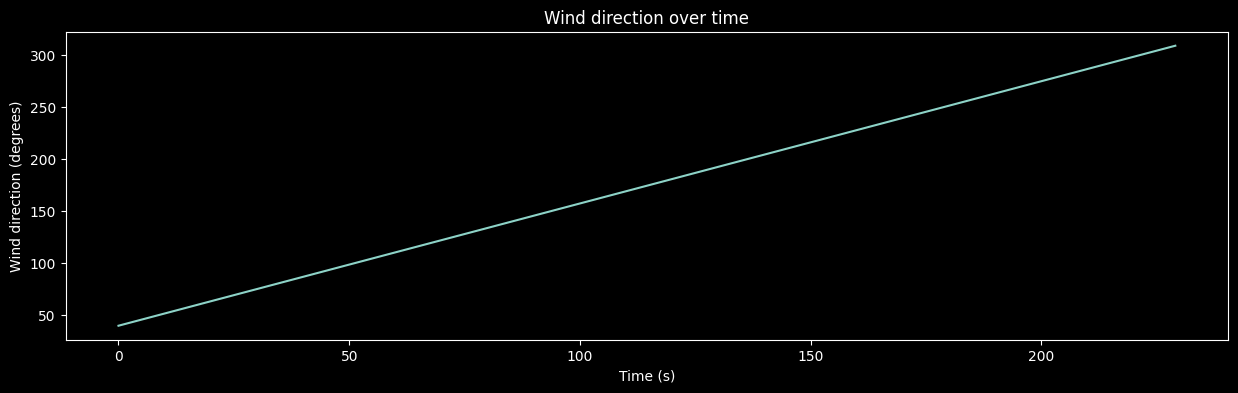

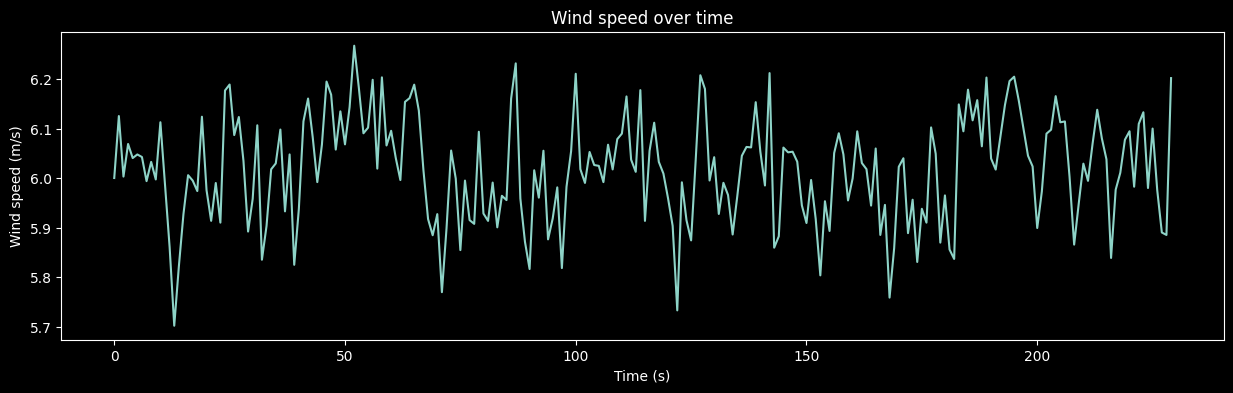

In [29]:
# Changing wind speed and direction : ---------------------------------------------
gaussianplume.wind_direction_plot(save, format='png')
gaussianplume.wind_speed_plot(save, format='png')

<Figure size 1000x1000 with 0 Axes>

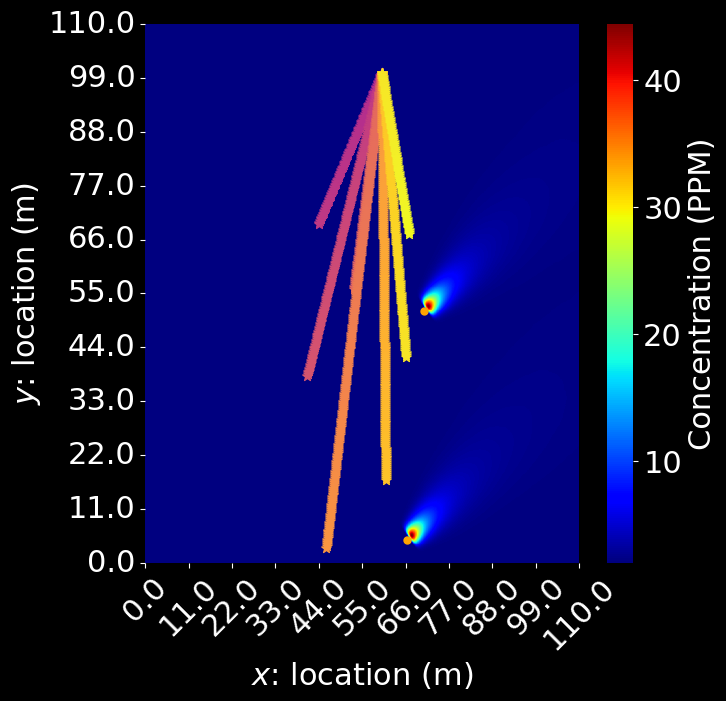

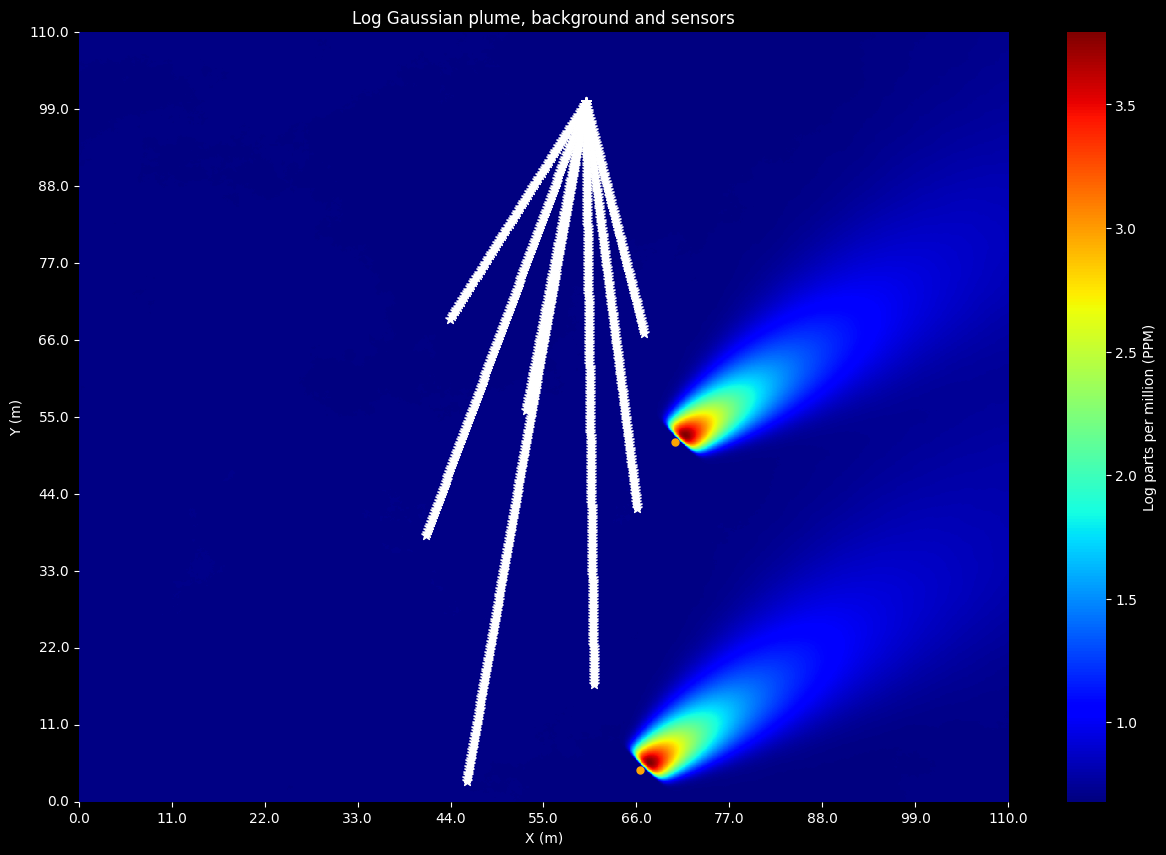

In [30]:
# Sensors Class : ---------------------------------------------
sensors = gp.Sensors(gaussianplume, background, sensors_settings)
sensors.atmospheric_methane_and_sensors(save, format='png')
sensors.log_atmospheric_methane_and_sensors(save, format='png')

In [31]:
# Data
truth = sensors.temporal_sensors_measurements(grided=False, beam=True)
data = truth[0]

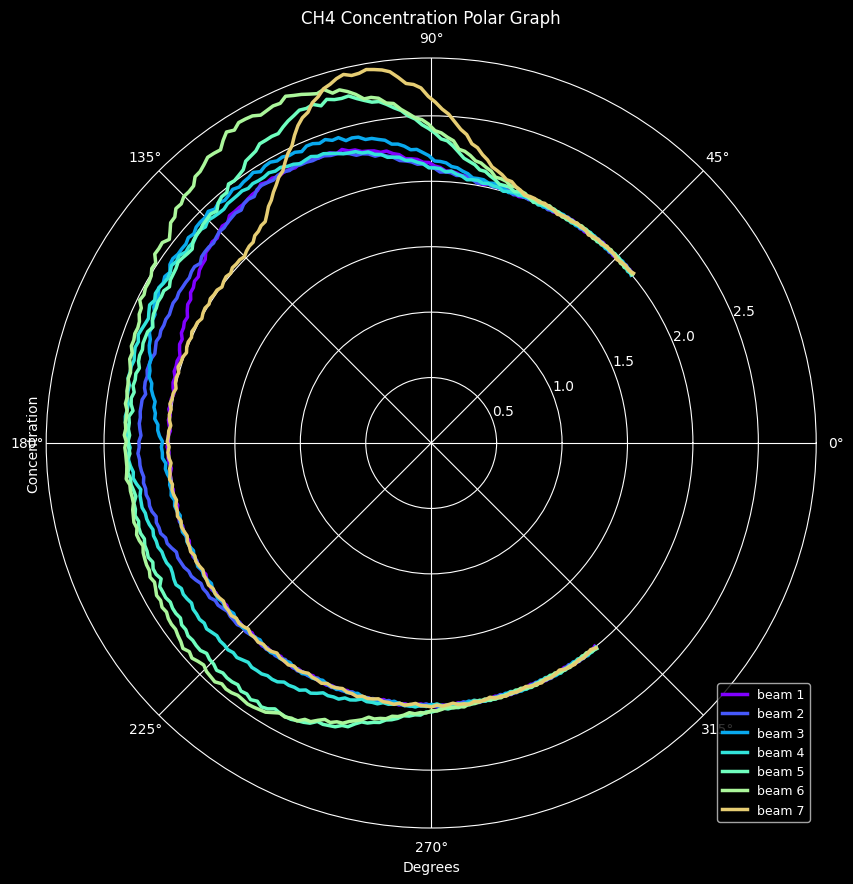

In [32]:
def plot_polar_graph(degrees_list, concentrations_list):
    # Set the style to 'dark_background'
    plt.style.use('dark_background')

    # Create a polar plot
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)
    labels = ["beam 1", "beam 2", "beam 3", "beam 4", "beam 5", "beam 6", "beam 7"]  # Replace with your actual labels
    # Create a color map
    colors = cm.rainbow(np.linspace(0, 0.7, len(labels)))
    # Plot each line
    for degrees, concentrations, label, color in zip(degrees_list, concentrations_list, labels, colors):
        # Convert degrees to radians
        radians = jnp.deg2rad(degrees)
        ax.plot(radians, concentrations, label = label, color=color, lw=2.5)
        # ax.fill(radians, concentrations, alpha=0.2, color=color)  # Fill the area under the line

    # Set the title and labels
    ax.set_title("CH4 Concentration Polar Graph", color='white')
    ax.set_xlabel("Degrees", color='white')
    ax.set_ylabel("Concentration", color='white')
    ax.legend(loc='lower right', prop={'size': 9})

    # Show the plot
    plt.show()

# Example usage:
degrees_list = [gaussianplume.wind_direction(), gaussianplume.wind_direction(),gaussianplume.wind_direction(), gaussianplume.wind_direction(), gaussianplume.wind_direction(), gaussianplume.wind_direction(), gaussianplume.wind_direction()]
concentrations_list = [data[:wind_field.number_of_time_steps], data[wind_field.number_of_time_steps:2*wind_field.number_of_time_steps], data[2*wind_field.number_of_time_steps:3*wind_field.number_of_time_steps], data[3*wind_field.number_of_time_steps:4*wind_field.number_of_time_steps], data[4*wind_field.number_of_time_steps:5*wind_field.number_of_time_steps], data[5*wind_field.number_of_time_steps:6*wind_field.number_of_time_steps], data[6*wind_field.number_of_time_steps:7*wind_field.number_of_time_steps]]
plot_polar_graph(degrees_list, concentrations_list)

<br><br><br><br><br>

## 3. Source 3 and Source 4 Parameter Estimation

### 3.1 Grid Search

Here we only estimate source emission rate and location while fixing background gas concentration, measurement error variance and dispersion parameters.

In [33]:
emission_granulaty_in_kg_per_s = 0.001/3
location_granulaty_in_m = 100/10
s_range = np.arange(0, 0.001, emission_granulaty_in_kg_per_s)
x_range = np.arange(0, 100, location_granulaty_in_m)
y_range = np.arange(0, 100, location_granulaty_in_m)

def get_ranges_combinations(x, y):
    xx, yy = np.meshgrid(x, y)
    combinations = np.vstack([xx.ravel(), yy.ravel()]).T
    return combinations

ranges = []
ranges.append(get_ranges_combinations(s_range,s_range))
ranges.append(get_ranges_combinations(x_range,x_range))
ranges.append(get_ranges_combinations(y_range,y_range))

ranges

[array([[0.        , 0.        ],
        [0.00033333, 0.        ],
        [0.00066667, 0.        ],
        [0.        , 0.00033333],
        [0.00033333, 0.00033333],
        [0.00066667, 0.00033333],
        [0.        , 0.00066667],
        [0.00033333, 0.00066667],
        [0.00066667, 0.00066667]]),
 array([[ 0.,  0.],
        [10.,  0.],
        [20.,  0.],
        [30.,  0.],
        [40.,  0.],
        [50.,  0.],
        [60.,  0.],
        [70.,  0.],
        [80.,  0.],
        [90.,  0.],
        [ 0., 10.],
        [10., 10.],
        [20., 10.],
        [30., 10.],
        [40., 10.],
        [50., 10.],
        [60., 10.],
        [70., 10.],
        [80., 10.],
        [90., 10.],
        [ 0., 20.],
        [10., 20.],
        [20., 20.],
        [30., 20.],
        [40., 20.],
        [50., 20.],
        [60., 20.],
        [70., 20.],
        [80., 20.],
        [90., 20.],
        [ 0., 30.],
        [10., 30.],
        [20., 30.],
        [30., 30.],
        [40.

In [34]:
def search_likelihood(s, x, y, initial_sgm, initial_betas, scheme, stability_class, number_time_steps, release_17=False):
    """
    Returns the positive log posterior of the point sensors measurements model. 

    """
    if stability_class == False:
        stability_class = None
        estimated = True
    else:
        estimated = False
        
    coupling_matrix_ref1 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref1, x, y, None, 1.0, 1.0, 1.0, 1.0, simulation=True, estimated=estimated, scheme=scheme, stability_class=stability_class)
    coupling_matrix_ref2 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref2, x, y, None, 1.0, 1.0, 1.0, 1.0, simulation=True, estimated=estimated, scheme=scheme, stability_class=stability_class)
    coupling_matrix_ref3 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref3, x, y, None, 1.0, 1.0, 1.0, 1.0, simulation=True, estimated=estimated, scheme=scheme, stability_class=stability_class)
    coupling_matrix_ref4 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref4, x, y, None, 1.0, 1.0, 1.0, 1.0, simulation=True, estimated=estimated, scheme=scheme, stability_class=stability_class)
    coupling_matrix_ref5 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref5, x, y, None, 1.0, 1.0, 1.0, 1.0, simulation=True, estimated=estimated, scheme=scheme, stability_class=stability_class)
    coupling_matrix_ref6 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref6, x, y, None, 1.0, 1.0, 1.0, 1.0, simulation=True, estimated=estimated, scheme=scheme, stability_class=stability_class)
    coupling_matrix_ref7 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref7, x, y, None, 1.0, 1.0, 1.0, 1.0, simulation=True, estimated=estimated, scheme=scheme, stability_class=stability_class)
    
    if release_17:
        reshaped_coupling_matrix_ref1_src1 = coupling_matrix_ref1[:,0].reshape(number_time_steps,18*5, order='F')
        reshaped_coupling_matrix_ref1_src2 = coupling_matrix_ref1[:,1].reshape(number_time_steps,18*5, order='F')
        reshaped_coupling_matrix_ref2_src1 = coupling_matrix_ref2[:,0].reshape(number_time_steps,33*5, order='F')
        reshaped_coupling_matrix_ref2_src2 = coupling_matrix_ref2[:,1].reshape(number_time_steps,33*5, order='F')
        reshaped_coupling_matrix_ref3_src1 = coupling_matrix_ref3[:,0].reshape(number_time_steps,22*5, order='F')
        reshaped_coupling_matrix_ref3_src2 = coupling_matrix_ref3[:,1].reshape(number_time_steps,22*5, order='F')
        reshaped_coupling_matrix_ref4_src1 = coupling_matrix_ref4[:,0].reshape(number_time_steps,49*5, order='F')
        reshaped_coupling_matrix_ref4_src2 = coupling_matrix_ref4[:,1].reshape(number_time_steps,49*5, order='F')
        reshaped_coupling_matrix_ref5_src1 = coupling_matrix_ref5[:,0].reshape(number_time_steps,42*5, order='F')
        reshaped_coupling_matrix_ref5_src2 = coupling_matrix_ref5[:,1].reshape(number_time_steps,42*5, order='F')
        reshaped_coupling_matrix_ref6_src1 = coupling_matrix_ref6[:,0].reshape(number_time_steps,29*5, order='F')
        reshaped_coupling_matrix_ref6_src2 = coupling_matrix_ref6[:,1].reshape(number_time_steps,29*5, order='F')
        reshaped_coupling_matrix_ref7_src1 = coupling_matrix_ref7[:,0].reshape(number_time_steps,17*5, order='F')
        reshaped_coupling_matrix_ref7_src2 = coupling_matrix_ref7[:,1].reshape(number_time_steps,17*5, order='F')
    else:
        reshaped_coupling_matrix_ref1_src1 = coupling_matrix_ref1[:,0].reshape(number_time_steps,18*5, order='F')
        reshaped_coupling_matrix_ref1_src2 = coupling_matrix_ref1[:,1].reshape(number_time_steps,18*5, order='F')
        reshaped_coupling_matrix_ref2_src1 = coupling_matrix_ref2[:,0].reshape(number_time_steps,33*5, order='F')
        reshaped_coupling_matrix_ref2_src2 = coupling_matrix_ref2[:,1].reshape(number_time_steps,33*5, order='F')
        reshaped_coupling_matrix_ref3_src1 = coupling_matrix_ref3[:,0].reshape(number_time_steps,22*5, order='F')
        reshaped_coupling_matrix_ref3_src2 = coupling_matrix_ref3[:,1].reshape(number_time_steps,22*5, order='F')
        reshaped_coupling_matrix_ref4_src1 = coupling_matrix_ref4[:,0].reshape(number_time_steps,49*5, order='F')
        reshaped_coupling_matrix_ref4_src2 = coupling_matrix_ref4[:,1].reshape(number_time_steps,49*5, order='F')
        reshaped_coupling_matrix_ref5_src1 = coupling_matrix_ref5[:,0].reshape(number_time_steps,42*5, order='F')
        reshaped_coupling_matrix_ref5_src2 = coupling_matrix_ref5[:,1].reshape(number_time_steps,42*5, order='F')
        reshaped_coupling_matrix_ref6_src1 = coupling_matrix_ref6[:,0].reshape(number_time_steps,29*5, order='F')
        reshaped_coupling_matrix_ref6_src2 = coupling_matrix_ref6[:,1].reshape(number_time_steps,29*5, order='F')
        reshaped_coupling_matrix_ref7_src1 = coupling_matrix_ref7[:,0].reshape(number_time_steps,17*5, order='F')
        reshaped_coupling_matrix_ref7_src2 = coupling_matrix_ref7[:,1].reshape(number_time_steps,17*5, order='F')

    path_averaged_coupling_matrix_ref1_src1 = reshaped_coupling_matrix_ref1_src1.mean(axis=1)
    path_averaged_coupling_matrix_ref1_src2 = reshaped_coupling_matrix_ref1_src2.mean(axis=1)
    path_averaged_coupling_matrix_ref2_src1 = reshaped_coupling_matrix_ref2_src1.mean(axis=1)
    path_averaged_coupling_matrix_ref2_src2 = reshaped_coupling_matrix_ref2_src2.mean(axis=1)
    path_averaged_coupling_matrix_ref3_src1 = reshaped_coupling_matrix_ref3_src1.mean(axis=1)
    path_averaged_coupling_matrix_ref3_src2 = reshaped_coupling_matrix_ref3_src2.mean(axis=1)
    path_averaged_coupling_matrix_ref4_src1 = reshaped_coupling_matrix_ref4_src1.mean(axis=1)
    path_averaged_coupling_matrix_ref4_src2 = reshaped_coupling_matrix_ref4_src2.mean(axis=1)
    path_averaged_coupling_matrix_ref5_src1 = reshaped_coupling_matrix_ref5_src1.mean(axis=1)
    path_averaged_coupling_matrix_ref5_src2 = reshaped_coupling_matrix_ref5_src2.mean(axis=1)
    path_averaged_coupling_matrix_ref6_src1 = reshaped_coupling_matrix_ref6_src1.mean(axis=1)
    path_averaged_coupling_matrix_ref6_src2 = reshaped_coupling_matrix_ref6_src2.mean(axis=1)
    path_averaged_coupling_matrix_ref7_src1 = reshaped_coupling_matrix_ref7_src1.mean(axis=1)
    path_averaged_coupling_matrix_ref7_src2 = reshaped_coupling_matrix_ref7_src2.mean(axis=1)
    
    source_1_path_averaged_A = [path_averaged_coupling_matrix_ref1_src1, path_averaged_coupling_matrix_ref2_src1, path_averaged_coupling_matrix_ref3_src1, path_averaged_coupling_matrix_ref4_src1, path_averaged_coupling_matrix_ref5_src1, path_averaged_coupling_matrix_ref6_src1, path_averaged_coupling_matrix_ref7_src1]
    source_2_path_averaged_A = [path_averaged_coupling_matrix_ref1_src2, path_averaged_coupling_matrix_ref2_src2, path_averaged_coupling_matrix_ref3_src2, path_averaged_coupling_matrix_ref4_src2, path_averaged_coupling_matrix_ref5_src2, path_averaged_coupling_matrix_ref6_src2, path_averaged_coupling_matrix_ref7_src2]
    
    if release_17 == False:
        source_1_A = jnp.array(source_1_path_averaged_A).reshape(-1,1)
        source_2_A = jnp.array(source_2_path_averaged_A).reshape(-1,1)
        A = jnp.concatenate([source_1_A, source_2_A], axis=1)
        log_likelihood = tfd.Normal(loc = (jnp.matmul(A,s.reshape(-1,1)) + jnp.repeat(initial_betas, number_time_steps).reshape(-1,1)), \
                                    scale= jnp.sqrt(initial_sgm)).log_prob(data)
        log_posterior = jnp.sum(log_likelihood)
    else:
        source_1_A = jnp.array([item for sublist in source_1_path_averaged_A for item in sublist]).reshape((number_time_steps*6)+number_time_steps,2)
        source_2_A = jnp.array([item for sublist in source_2_path_averaged_A for item in sublist]).reshape((number_time_steps*6)+number_time_steps,2)
        A = jnp.concatenate([source_1_A, source_2_A], axis=1)
        log_likelihood = tfd.Normal(loc = (jnp.matmul(A,s.reshape(-1,1)) + jnp.repeat(initial_betas.mean(), (number_time_steps*6)+number_time_steps).reshape(-1,1)), \
                                    scale= jnp.sqrt(initial_sgm)).log_prob(data)

    return log_posterior

In [35]:
# Generate all combinations of parameters
sources_param = jnp.zeros(len(ranges)*2)
parameter_combinations = jnp.array(list(itertools.product(*ranges[:len(ranges)+1])))
print(f"Number of parameter combinations: {parameter_combinations.shape[0]}")

Number of parameter combinations: 90000


In [36]:
# Initial parameter values for:

# Sensor measurement error variance
initial_sgm = 1e-5
# Background gas concentration
initial_betas = jnp.repeat(1.92, 7)

# Step function
def one_step(_, parameters):
    s, x, y = parameters[0], parameters[1], parameters[2]
    new_likelihood = search_likelihood(s, x, y, initial_sgm, initial_betas, "Draxler", False, wind_field.number_of_time_steps, release_17=False)
    return new_likelihood, new_likelihood
# Use lax.scan to iterate over the parameter combinations
_, likelihoods = lax.scan(one_step, 0.0, parameter_combinations)
# Analysing output
likelihood_df = pd.DataFrame(likelihoods, columns = ['log_likelihood'])
parameters_df = pd.DataFrame(parameter_combinations.reshape(-1,6), columns = ["s1", "s2", "x1", "x2", "y1", "y2"])
max_likelihood_index = likelihood_df.idxmax()
max_likelihood_row = parameters_df.iloc[max_likelihood_index]
sources_param = sources_param.at[:].set(max_likelihood_row.values.flatten())
print(f"Grid search maximum likelihood estimation of emission rate and location:")
print(max_likelihood_row)

rate_1 = max_likelihood_row.values.flatten()[0]
rate_2 = max_likelihood_row.values.flatten()[1]
loc_x_1 = max_likelihood_row.values.flatten()[2]
loc_x_2 = max_likelihood_row.values.flatten()[3]
loc_y_1 = max_likelihood_row.values.flatten()[4]
loc_y_2 = max_likelihood_row.values.flatten()[5]

Grid search maximum likelihood estimation of emission rate and location:
             s1        s2    x1    x2   y1    y2
57750  0.000667  0.000333  70.0  70.0  0.0  50.0


### 3.2 Latin Hypercube

Here we estimate all parameters simultaneously.

In [37]:
def latin_hypercube_sampling(param_ranges, num_samples):
    """
    Generate a Latin Hypercube Sample within specified parameter ranges.

    Parameters:
    param_ranges (list of tuple): A list of tuples specifying the range (min, max) for each parameter.
    num_samples (int): The number of samples to generate.

    Returns:
    numpy.ndarray: A num_samples x num_params matrix where each column corresponds to a parameter and each row corresponds to a sample.
    """
    num_params = len(param_ranges)
    
    # Generate the Latin Hypercube Sample
    lhd = lhs(num_params, num_samples)
    
    # Scale the samples to be within the parameter ranges
    for i in range(num_params):
        min_val, max_val = param_ranges[i]
        lhd[:, i] = lhd[:, i] * (max_val - min_val) + min_val

    return lhd


def latin_hypercube_likelihood(s1, s2, x1, x2, y1, y2, sgm, a_h, a_v, b_h, b_v, scheme, stability_class, number_time_steps, release_17=False):
    """
    Returns the positive log posterior of the point sensors measurements model. 

    """
    if stability_class == False:
        stability_class = None
        estimated = True
    else:
        estimated = False

    coupling_matrix_ref1 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref1, [x1,x2], [y1,y2], None, jnp.array(a_h), jnp.array(a_v), jnp.array(b_h), jnp.array(b_v), simulation=True, estimated=estimated, scheme=scheme, stability_class=stability_class)
    coupling_matrix_ref2 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref2, [x1,x2], [y1,y2], None, jnp.array(a_h), jnp.array(a_v), jnp.array(b_h), jnp.array(b_v), simulation=True, estimated=estimated, scheme=scheme, stability_class=stability_class)
    coupling_matrix_ref3 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref3, [x1,x2], [y1,y2], None, jnp.array(a_h), jnp.array(a_v), jnp.array(b_h), jnp.array(b_v), simulation=True, estimated=estimated, scheme=scheme, stability_class=stability_class)
    coupling_matrix_ref4 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref4, [x1,x2], [y1,y2], None, jnp.array(a_h), jnp.array(a_v), jnp.array(b_h), jnp.array(b_v), simulation=True, estimated=estimated, scheme=scheme, stability_class=stability_class)
    coupling_matrix_ref5 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref5, [x1,x2], [y1,y2], None, jnp.array(a_h), jnp.array(a_v), jnp.array(b_h), jnp.array(b_v), simulation=True, estimated=estimated, scheme=scheme, stability_class=stability_class)
    coupling_matrix_ref6 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref6, [x1,x2], [y1,y2], None, jnp.array(a_h), jnp.array(a_v), jnp.array(b_h), jnp.array(b_v), simulation=True, estimated=estimated, scheme=scheme, stability_class=stability_class)
    coupling_matrix_ref7 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref7, [x1,x2], [y1,y2], None, jnp.array(a_h), jnp.array(a_v), jnp.array(b_h), jnp.array(b_v), simulation=True, estimated=estimated, scheme=scheme, stability_class=stability_class)
    
    if release_17:
        reshaped_coupling_matrix_ref1_src1 = coupling_matrix_ref1[:,0].reshape(number_time_steps,18*5, order='F')
        reshaped_coupling_matrix_ref1_src2 = coupling_matrix_ref1[:,1].reshape(number_time_steps,18*5, order='F')
        reshaped_coupling_matrix_ref2_src1 = coupling_matrix_ref2[:,0].reshape(number_time_steps - 31,33*5, order='F')
        reshaped_coupling_matrix_ref2_src2 = coupling_matrix_ref2[:,1].reshape(number_time_steps - 31,33*5, order='F')
        reshaped_coupling_matrix_ref3_src1 = coupling_matrix_ref3[:,0].reshape(number_time_steps,22*5, order='F')
        reshaped_coupling_matrix_ref3_src2 = coupling_matrix_ref3[:,1].reshape(number_time_steps,22*5, order='F')
        reshaped_coupling_matrix_ref4_src1 = coupling_matrix_ref4[:,0].reshape(number_time_steps,49*5, order='F')
        reshaped_coupling_matrix_ref4_src2 = coupling_matrix_ref4[:,1].reshape(number_time_steps,49*5, order='F')
        reshaped_coupling_matrix_ref5_src1 = coupling_matrix_ref5[:,0].reshape(number_time_steps,42*5, order='F')
        reshaped_coupling_matrix_ref5_src2 = coupling_matrix_ref5[:,1].reshape(number_time_steps,42*5, order='F')
        reshaped_coupling_matrix_ref6_src1 = coupling_matrix_ref6[:,0].reshape(number_time_steps,29*5, order='F')
        reshaped_coupling_matrix_ref6_src2 = coupling_matrix_ref6[:,1].reshape(number_time_steps,29*5, order='F')
        reshaped_coupling_matrix_ref7_src1 = coupling_matrix_ref7[:,0].reshape(number_time_steps,17*5, order='F')
        reshaped_coupling_matrix_ref7_src2 = coupling_matrix_ref7[:,1].reshape(number_time_steps,17*5, order='F')
    else:
        reshaped_coupling_matrix_ref1_src1 = coupling_matrix_ref1[:,0].reshape(number_time_steps,18*5, order='F')
        reshaped_coupling_matrix_ref1_src2 = coupling_matrix_ref1[:,1].reshape(number_time_steps,18*5, order='F')
        reshaped_coupling_matrix_ref2_src1 = coupling_matrix_ref2[:,0].reshape(number_time_steps,33*5, order='F')
        reshaped_coupling_matrix_ref2_src2 = coupling_matrix_ref2[:,1].reshape(number_time_steps,33*5, order='F')
        reshaped_coupling_matrix_ref3_src1 = coupling_matrix_ref3[:,0].reshape(number_time_steps,22*5, order='F')
        reshaped_coupling_matrix_ref3_src2 = coupling_matrix_ref3[:,1].reshape(number_time_steps,22*5, order='F')
        reshaped_coupling_matrix_ref4_src1 = coupling_matrix_ref4[:,0].reshape(number_time_steps,49*5, order='F')
        reshaped_coupling_matrix_ref4_src2 = coupling_matrix_ref4[:,1].reshape(number_time_steps,49*5, order='F')
        reshaped_coupling_matrix_ref5_src1 = coupling_matrix_ref5[:,0].reshape(number_time_steps,42*5, order='F')
        reshaped_coupling_matrix_ref5_src2 = coupling_matrix_ref5[:,1].reshape(number_time_steps,42*5, order='F')
        reshaped_coupling_matrix_ref6_src1 = coupling_matrix_ref6[:,0].reshape(number_time_steps,29*5, order='F')
        reshaped_coupling_matrix_ref6_src2 = coupling_matrix_ref6[:,1].reshape(number_time_steps,29*5, order='F')
        reshaped_coupling_matrix_ref7_src1 = coupling_matrix_ref7[:,0].reshape(number_time_steps,17*5, order='F')
        reshaped_coupling_matrix_ref7_src2 = coupling_matrix_ref7[:,1].reshape(number_time_steps,17*5, order='F')
    
    path_averaged_coupling_matrix_ref1_src1 = reshaped_coupling_matrix_ref1_src1.mean(axis=1)
    path_averaged_coupling_matrix_ref1_src2 = reshaped_coupling_matrix_ref1_src2.mean(axis=1)
    path_averaged_coupling_matrix_ref2_src1 = reshaped_coupling_matrix_ref2_src1.mean(axis=1)
    path_averaged_coupling_matrix_ref2_src2 = reshaped_coupling_matrix_ref2_src2.mean(axis=1)
    path_averaged_coupling_matrix_ref3_src1 = reshaped_coupling_matrix_ref3_src1.mean(axis=1)
    path_averaged_coupling_matrix_ref3_src2 = reshaped_coupling_matrix_ref3_src2.mean(axis=1)
    path_averaged_coupling_matrix_ref4_src1 = reshaped_coupling_matrix_ref4_src1.mean(axis=1)
    path_averaged_coupling_matrix_ref4_src2 = reshaped_coupling_matrix_ref4_src2.mean(axis=1)
    path_averaged_coupling_matrix_ref5_src1 = reshaped_coupling_matrix_ref5_src1.mean(axis=1)
    path_averaged_coupling_matrix_ref5_src2 = reshaped_coupling_matrix_ref5_src2.mean(axis=1)
    path_averaged_coupling_matrix_ref6_src1 = reshaped_coupling_matrix_ref6_src1.mean(axis=1)
    path_averaged_coupling_matrix_ref6_src2 = reshaped_coupling_matrix_ref6_src2.mean(axis=1)
    path_averaged_coupling_matrix_ref7_src1 = reshaped_coupling_matrix_ref7_src1.mean(axis=1)
    path_averaged_coupling_matrix_ref7_src2 = reshaped_coupling_matrix_ref7_src2.mean(axis=1)

    source_1_path_averaged_A = [path_averaged_coupling_matrix_ref1_src1, path_averaged_coupling_matrix_ref2_src1, path_averaged_coupling_matrix_ref3_src1, path_averaged_coupling_matrix_ref4_src1, path_averaged_coupling_matrix_ref5_src1, path_averaged_coupling_matrix_ref6_src1, path_averaged_coupling_matrix_ref7_src1]
    source_2_path_averaged_A = [path_averaged_coupling_matrix_ref1_src2, path_averaged_coupling_matrix_ref2_src2, path_averaged_coupling_matrix_ref3_src2, path_averaged_coupling_matrix_ref4_src2, path_averaged_coupling_matrix_ref5_src2, path_averaged_coupling_matrix_ref6_src2, path_averaged_coupling_matrix_ref7_src2]
    
    if release_17 == False:
        source_1_A = jnp.array(source_1_path_averaged_A).reshape(-1,1)
        source_2_A = jnp.array(source_2_path_averaged_A).reshape(-1,1)
        A = jnp.concatenate([source_1_A, source_2_A], axis=1)
        log_likelihood = tfd.Normal(loc = (jnp.matmul(A,jnp.array([s1,s2]).reshape(-1,1)) + jnp.repeat(initial_betas, number_time_steps).reshape(-1,1)), \
                                    scale= jnp.sqrt(sgm)).log_prob(data)
        log_posterior = jnp.sum(log_likelihood)
    else:
        source_1_A = jnp.array([item for sublist in source_1_path_averaged_A for item in sublist]).reshape((number_time_steps*6)+number_time_steps,2)
        source_2_A = jnp.array([item for sublist in source_2_path_averaged_A for item in sublist]).reshape((number_time_steps*6)+number_time_steps,2)
        A = jnp.concatenate([source_1_A, source_2_A], axis=1)
        log_likelihood = tfd.Normal(loc = (jnp.matmul(A,jnp.array([s1,s2]).reshape(-1,1)) + jnp.repeat(initial_betas.mean(), (number_time_steps*6)+number_time_steps).reshape(-1,1)), \
                                    scale= jnp.sqrt(sgm)).log_prob(data)

    return log_posterior

param_ranges = []
param_ranges.append((np.maximum(0, rate_1 - emission_granulaty_in_kg_per_s), rate_1 + emission_granulaty_in_kg_per_s))
param_ranges.append((np.maximum(0, rate_2 - emission_granulaty_in_kg_per_s), rate_2 + emission_granulaty_in_kg_per_s))
param_ranges.append((loc_x_1 - location_granulaty_in_m, loc_x_1 + location_granulaty_in_m))
param_ranges.append((loc_x_2 - location_granulaty_in_m, loc_x_2 + location_granulaty_in_m))
param_ranges.append((loc_y_1 - location_granulaty_in_m, loc_y_1 + location_granulaty_in_m))
param_ranges.append((loc_y_2 - location_granulaty_in_m, loc_y_2 + location_granulaty_in_m))
param_ranges.append((0, 1e-4))
param_ranges.append((0.5, 1.2))
param_ranges.append((0.5, 1.2))
param_ranges.append((0.5, 1.01))
param_ranges.append((0.5, 1.01))


num_samples = 20_000
lh_samples = latin_hypercube_sampling(param_ranges, num_samples)
# Step function
def lh_one_step(_, parameters):
    rate_1, rate_2, loc_x_1, loc_x_2, loc_y_1, loc_y_2, sgm, a_h, a_v, b_h, b_v = parameters
    new_likelihood = latin_hypercube_likelihood(rate_1, rate_2, loc_x_1, loc_x_2, loc_y_1, loc_y_2, sgm, a_h, a_v, b_h, b_v, "Draxler", False, wind_field.number_of_time_steps)
    return new_likelihood, new_likelihood
# Use lax.scan to iterate over the parameter combinations
_, lh_likelihoods = lax.scan(lh_one_step, 0.0, lh_samples)

# Analysing output
lh_likelihood_df = pd.DataFrame(lh_likelihoods, columns = ['log_likelihood'])
lh_parameters_df = pd.DataFrame(lh_samples, columns = ['s_1', 's_2', 'x_1', 'x_2', 'y_1', 'y_2', 'sgm', 'a_h', 'a_v', 'b_h', 'b_v'])
lh_max_likelihood_index = lh_likelihood_df.idxmax()
lh_max_likelihood_row = lh_parameters_df.iloc[lh_max_likelihood_index]
print(f"Latin Hypercube maximum likelihood estimation:")
lh_max_likelihood_row

Latin Hypercube maximum likelihood estimation:


,s_1,s_2,x_1,x_2,y_1,y_2,sgm,a_h,a_v,b_h,b_v
4172,0.000818,0.000351,73.250019,69.593793,2.416695,51.49804,0.000097,0.971654,1.169352,1.005516,0.985733


<br>

### 3.3 Manifold-Metropolis-within-Gibbs

Here we estimate all parameters simultaneously.

In [38]:
initial_log_rates = jnp.log(lh_max_likelihood_row[['s_' + str(i+1) for i in range(int(len(ranges)/3)*2)]].values.flatten())
initial_locations_x = lh_max_likelihood_row[['x_' + str(i+1) for i in range(int(len(ranges)/3)*2)]].values.flatten()
initial_locations_y = lh_max_likelihood_row[['y_' + str(i+1) for i in range(int(len(ranges)/3)*2)]].values.flatten()
initial_sgm_sqr = lh_max_likelihood_row.values.flatten()[6]
initial_log_a_h = jnp.log(lh_max_likelihood_row.values.flatten()[7])
initial_log_a_v = jnp.log(lh_max_likelihood_row.values.flatten()[8])
initial_log_b_h = jnp.log(lh_max_likelihood_row.values.flatten()[9])
initial_log_b_v = jnp.log(lh_max_likelihood_row.values.flatten()[10])


print(f"Setting Initial Parameter Values:")
print(f"--------------------------------")
print(f"Initial rates: {initial_log_rates}")
print(f"Initial locations x: {initial_locations_x}")
print(f"Initial locations y: {initial_locations_y}")
print(f"Initial sgm sqr: {initial_sgm_sqr}")
print(f"Initial a_h: {initial_log_a_h}")
print(f"Initial a_v: {initial_log_a_v}")
print(f"Initial b_h: {initial_log_b_h}")
print(f"Initial b_v: {initial_log_b_v}")

Setting Initial Parameter Values:
--------------------------------
Initial rates: [-7.10917829 -7.95474854]
Initial locations x: [73.25001917 69.59379278]
Initial locations y: [ 2.41669514 51.4980404 ]
Initial sgm sqr: 9.738512369449028e-05
Initial a_h: -0.028755078445129378
Initial a_v: 0.15645006978404938
Initial b_h: 0.005500698012769556
Initial b_v: -0.01436960726710032


In [39]:
Gibbsparams = {
    'background': initial_betas,
    'sigma_squared':   initial_sgm_sqr,
}
gibbs_flat, gibbs_unflat_func = ravel_pytree(Gibbsparams)

MHparams = {
    'log_a_H': initial_log_a_h,
    'log_a_V': initial_log_a_v,
    'log_b_H':  initial_log_b_h,
    'log_b_V': initial_log_b_v,
    'log_s': jnp.array(initial_log_rates),
    'source_x': jnp.array(initial_locations_x),
    'source_y': jnp.array(initial_locations_y),
}
mh_flat, mh_unflat_func = ravel_pytree(MHparams)


def log_posterior(params, sigma_squared, betas, ss_var, ss_mean, data, priors, wind_sigma, number_of_time_steps, release_17=False):
    """
    Returns the positive log posterior of the point sensors measurements model. 

    """
    if wind_sigma == True:
        coupling_matrix_ref1 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref1, params["source_x"], params["source_y"], None, jnp.exp(params["log_a_H"]), jnp.exp(params["log_a_V"]), jnp.exp(params["log_b_H"]), jnp.exp(params["log_b_V"]), simulation=True, estimated=True, scheme="Draxler", stability_class="D")
        coupling_matrix_ref2 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref2, params["source_x"], params["source_y"], None, jnp.exp(params["log_a_H"]), jnp.exp(params["log_a_V"]), jnp.exp(params["log_b_H"]), jnp.exp(params["log_b_V"]), simulation=True, estimated=True, scheme="Draxler", stability_class="D")
        coupling_matrix_ref3 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref3, params["source_x"], params["source_y"], None, jnp.exp(params["log_a_H"]), jnp.exp(params["log_a_V"]), jnp.exp(params["log_b_H"]), jnp.exp(params["log_b_V"]), simulation=True, estimated=True, scheme="Draxler", stability_class="D")
        coupling_matrix_ref4 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref4, params["source_x"], params["source_y"], None, jnp.exp(params["log_a_H"]), jnp.exp(params["log_a_V"]), jnp.exp(params["log_b_H"]), jnp.exp(params["log_b_V"]), simulation=True, estimated=True, scheme="Draxler", stability_class="D")
        coupling_matrix_ref5 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref5, params["source_x"], params["source_y"], None, jnp.exp(params["log_a_H"]), jnp.exp(params["log_a_V"]), jnp.exp(params["log_b_H"]), jnp.exp(params["log_b_V"]), simulation=True, estimated=True, scheme="Draxler", stability_class="D")
        coupling_matrix_ref6 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref6, params["source_x"], params["source_y"], None, jnp.exp(params["log_a_H"]), jnp.exp(params["log_a_V"]), jnp.exp(params["log_b_H"]), jnp.exp(params["log_b_V"]), simulation=True, estimated=True, scheme="Draxler", stability_class="D")
        coupling_matrix_ref7 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref7, params["source_x"], params["source_y"], None, jnp.exp(params["log_a_H"]), jnp.exp(params["log_a_V"]), jnp.exp(params["log_b_H"]), jnp.exp(params["log_b_V"]), simulation=True, estimated=True, scheme="Draxler", stability_class="D")
    elif wind_sigma == False:
        coupling_matrix_ref1 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref1,params["source_x"],params["source_y"], None, False, False, False, False, simulation=True, estimated=True, scheme="Draxler", stability_class="D")
        coupling_matrix_ref2 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref2,params["source_x"],params["source_y"], None, False, False, False, False, simulation=True, estimated=True, scheme="Draxler", stability_class="D")
        coupling_matrix_ref3 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref3,params["source_x"],params["source_y"], None, False, False, False, False, simulation=True, estimated=True, scheme="Draxler", stability_class="D")
        coupling_matrix_ref4 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref4,params["source_x"],params["source_y"], None, False, False, False, False, simulation=True, estimated=True, scheme="Draxler", stability_class="D")
        coupling_matrix_ref5 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref5,params["source_x"],params["source_y"], None, False, False, False, False, simulation=True, estimated=True, scheme="Draxler", stability_class="D")
        coupling_matrix_ref6 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref6,params["source_x"],params["source_y"], None, False, False, False, False, simulation=True, estimated=True, scheme="Draxler", stability_class="D")
        coupling_matrix_ref7 = gaussianplume.temporal_gridfree_coupling_matrix(fixed_ref7,params["source_x"],params["source_y"], None, False, False, False, False, simulation=True, estimated=True, scheme="Draxler", stability_class="D")
    if release_17:
        reshaped_coupling_matrix_ref1_src1 = coupling_matrix_ref1[:,0].reshape(number_of_time_steps,18*5, order='F')
        reshaped_coupling_matrix_ref1_src2 = coupling_matrix_ref1[:,1].reshape(number_of_time_steps,18*5, order='F')
        reshaped_coupling_matrix_ref2_src1 = coupling_matrix_ref2[:,0].reshape(number_of_time_steps - 31,33*5, order='F')
        reshaped_coupling_matrix_ref2_src2 = coupling_matrix_ref2[:,1].reshape(number_of_time_steps - 31,33*5, order='F')
        reshaped_coupling_matrix_ref3_src1 = coupling_matrix_ref3[:,0].reshape(number_of_time_steps,22*5, order='F')
        reshaped_coupling_matrix_ref3_src2 = coupling_matrix_ref3[:,1].reshape(number_of_time_steps,22*5, order='F')
        reshaped_coupling_matrix_ref4_src1 = coupling_matrix_ref4[:,0].reshape(number_of_time_steps,49*5, order='F')
        reshaped_coupling_matrix_ref4_src2 = coupling_matrix_ref4[:,1].reshape(number_of_time_steps,49*5, order='F')
        reshaped_coupling_matrix_ref5_src1 = coupling_matrix_ref5[:,0].reshape(number_of_time_steps,42*5, order='F')
        reshaped_coupling_matrix_ref5_src2 = coupling_matrix_ref5[:,1].reshape(number_of_time_steps,42*5, order='F')
        reshaped_coupling_matrix_ref6_src1 = coupling_matrix_ref6[:,0].reshape(number_of_time_steps,29*5, order='F')
        reshaped_coupling_matrix_ref6_src2 = coupling_matrix_ref6[:,1].reshape(number_of_time_steps,29*5, order='F')
        reshaped_coupling_matrix_ref7_src1 = coupling_matrix_ref7[:,0].reshape(number_of_time_steps,17*5, order='F')
        reshaped_coupling_matrix_ref7_src2 = coupling_matrix_ref7[:,1].reshape(number_of_time_steps,17*5, order='F')
    else:
        reshaped_coupling_matrix_ref1_src1 = coupling_matrix_ref1[:,0].reshape(number_of_time_steps,18*5, order='F')
        reshaped_coupling_matrix_ref1_src2 = coupling_matrix_ref1[:,1].reshape(number_of_time_steps,18*5, order='F')
        reshaped_coupling_matrix_ref2_src1 = coupling_matrix_ref2[:,0].reshape(number_of_time_steps,33*5, order='F')
        reshaped_coupling_matrix_ref2_src2 = coupling_matrix_ref2[:,1].reshape(number_of_time_steps,33*5, order='F')
        reshaped_coupling_matrix_ref3_src1 = coupling_matrix_ref3[:,0].reshape(number_of_time_steps,22*5, order='F')
        reshaped_coupling_matrix_ref3_src2 = coupling_matrix_ref3[:,1].reshape(number_of_time_steps,22*5, order='F')
        reshaped_coupling_matrix_ref4_src1 = coupling_matrix_ref4[:,0].reshape(number_of_time_steps,49*5, order='F')
        reshaped_coupling_matrix_ref4_src2 = coupling_matrix_ref4[:,1].reshape(number_of_time_steps,49*5, order='F')
        reshaped_coupling_matrix_ref5_src1 = coupling_matrix_ref5[:,0].reshape(number_of_time_steps,42*5, order='F')
        reshaped_coupling_matrix_ref5_src2 = coupling_matrix_ref5[:,1].reshape(number_of_time_steps,42*5, order='F')
        reshaped_coupling_matrix_ref6_src1 = coupling_matrix_ref6[:,0].reshape(number_of_time_steps,29*5, order='F')
        reshaped_coupling_matrix_ref6_src2 = coupling_matrix_ref6[:,1].reshape(number_of_time_steps,29*5, order='F')
        reshaped_coupling_matrix_ref7_src1 = coupling_matrix_ref7[:,0].reshape(number_of_time_steps,17*5, order='F')
        reshaped_coupling_matrix_ref7_src2 = coupling_matrix_ref7[:,1].reshape(number_of_time_steps,17*5, order='F')

    path_averaged_coupling_matrix_ref1_src1 = reshaped_coupling_matrix_ref1_src1.mean(axis=1)
    path_averaged_coupling_matrix_ref1_src2 = reshaped_coupling_matrix_ref1_src2.mean(axis=1)
    path_averaged_coupling_matrix_ref2_src1 = reshaped_coupling_matrix_ref2_src1.mean(axis=1)
    path_averaged_coupling_matrix_ref2_src2 = reshaped_coupling_matrix_ref2_src2.mean(axis=1)
    path_averaged_coupling_matrix_ref3_src1 = reshaped_coupling_matrix_ref3_src1.mean(axis=1)
    path_averaged_coupling_matrix_ref3_src2 = reshaped_coupling_matrix_ref3_src2.mean(axis=1)
    path_averaged_coupling_matrix_ref4_src1 = reshaped_coupling_matrix_ref4_src1.mean(axis=1)
    path_averaged_coupling_matrix_ref4_src2 = reshaped_coupling_matrix_ref4_src2.mean(axis=1)
    path_averaged_coupling_matrix_ref5_src1 = reshaped_coupling_matrix_ref5_src1.mean(axis=1)
    path_averaged_coupling_matrix_ref5_src2 = reshaped_coupling_matrix_ref5_src2.mean(axis=1)
    path_averaged_coupling_matrix_ref6_src1 = reshaped_coupling_matrix_ref6_src1.mean(axis=1)
    path_averaged_coupling_matrix_ref6_src2 = reshaped_coupling_matrix_ref6_src2.mean(axis=1)
    path_averaged_coupling_matrix_ref7_src1 = reshaped_coupling_matrix_ref7_src1.mean(axis=1)
    path_averaged_coupling_matrix_ref7_src2 = reshaped_coupling_matrix_ref7_src2.mean(axis=1)
    
    source_1_path_averaged_A = [path_averaged_coupling_matrix_ref1_src1, path_averaged_coupling_matrix_ref2_src1, path_averaged_coupling_matrix_ref3_src1, path_averaged_coupling_matrix_ref4_src1, path_averaged_coupling_matrix_ref5_src1, path_averaged_coupling_matrix_ref6_src1, path_averaged_coupling_matrix_ref7_src1]
    source_2_path_averaged_A = [path_averaged_coupling_matrix_ref1_src2, path_averaged_coupling_matrix_ref2_src2, path_averaged_coupling_matrix_ref3_src2, path_averaged_coupling_matrix_ref4_src2, path_averaged_coupling_matrix_ref5_src2, path_averaged_coupling_matrix_ref6_src2, path_averaged_coupling_matrix_ref7_src2]
    source_1_A = jnp.array(source_1_path_averaged_A).reshape(-1,1)
    source_2_A = jnp.array(source_2_path_averaged_A).reshape(-1,1)

    A = jnp.concatenate([source_1_A, source_2_A], axis=1)

    log_likelihood = tfd.Normal(loc = (jnp.matmul(A,jnp.exp(params["log_s"]).reshape(-1,1))+ betas), \
                                scale= jnp.sqrt(sigma_squared)).log_prob(data)

    if wind_sigma == True:
        log_prior_a_H = tfd.Normal(loc = priors.a_mean, scale = jnp.sqrt(priors.a_var)).log_prob(params["log_a_H"])
        log_prior_a_V = tfd.Normal(loc = priors.a_mean, scale = jnp.sqrt(priors.a_var)).log_prob(params["log_a_V"])
        log_prior_b_H = tfd.Normal(loc = priors.b_mean, scale = jnp.sqrt(priors.b_var)).log_prob(params["log_b_H"])
        log_prior_b_V = tfd.Normal(loc = priors.b_mean, scale = jnp.sqrt(priors.b_var)).log_prob(params["log_b_V"])

    log_posterior_emission_rate = tfd.MultivariateNormalDiag(loc = ss_mean, scale_diag = jnp.sqrt(ss_var)).log_prob(params["log_s"].reshape(-1,1))
    log_posterior_source_location = tfd.MultivariateNormalDiag(loc = jnp.array([priors.source_location_x_mean, priors.source_location_x_mean, priors.source_location_y_mean, priors.source_location_y_mean]), \
                                                                scale_diag = jnp.sqrt(jnp.array([priors.source_location_x_var, priors.source_location_x_var, priors.source_location_y_var, priors.source_location_y_var]))).log_prob(jnp.array([params["source_x"], params["source_y"]]).flatten())

    if wind_sigma == True:
        log_posterior = jnp.sum(log_likelihood) + jnp.sum(log_posterior_source_location) + jnp.sum(log_posterior_emission_rate) + jnp.sum(log_prior_a_H) + jnp.sum(log_prior_a_V) + jnp.sum(log_prior_b_H) + jnp.sum(log_prior_b_V) 
    elif wind_sigma == False:
        log_posterior = jnp.sum(log_likelihood) + jnp.sum(log_posterior_source_location) + jnp.sum(log_posterior_emission_rate)

    return log_posterior, A



In [54]:
iterations = 30_000
initial_step_size = 0.01
# Run the MCMC algorithm
mala_chains = mcmc.Manifold_MALA_Within_Gibbs(False, gaussianplume, data, log_posterior, priors, MHparams, Gibbsparams, fixed, chilbolton=True, wind_sigmas=True, release_17 = False, step_size_tuning="False").manifold_mala_chains(Gibbsparams, mh_flat, iterations, initial_step_size, release_17=False)


2024-07-29 13:24:55.554873: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m27.820233625s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Running time Manifold MALA within Gibbs: 960 minutes 2 seconds
